In [11]:
# Cell 1
# Import needed libraries and create functions necessary for processing

# --- Install Commands (commented out) ---
%pip install kagglehub
%pip install torch skorch
%pip install kaggle
%pip install kagglehub[pandas-datasets]

# --- Standard Libraries ---
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from urllib import request
from zipfile import ZipFile
import re
from collections import Counter

# --- Scikit-learn Tools ---
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# --- Deep Learning Tools ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets, models, transforms
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

# --- Kagglehub for Dataset ---
import kagglehub

# --- Helper Functions ---

# Helper function to create a dataframe with selected features and sample size
def get_features_df(csv_name, chosen_features, sample_decimal_size):
    df = pd.read_csv(csv_name).sample(frac=sample_decimal_size, random_state=2)
    df = df[chosen_features]
    df.dropna(inplace=True)
    return df

# Helper function to tokenize text
def tokenize(text):
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove punctuation
    return text.lower().split()

# Helper function to build vocabulary from training data
def build_vocab(texts, min_freq=2):
    counter = Counter()
    for text in texts:
        tokens = tokenize(text)
        counter.update(tokens)
    vocab = {"<PAD>": 0, "<UNK>": 1}
    for word, freq in counter.items():
        if freq >= min_freq:
            vocab[word] = len(vocab)
    return vocab

# Helper function to convert text to sequence of integers
def text_to_sequence(text, vocab):
    tokens = tokenize(text)
    return [vocab.get(token, vocab["<UNK>"]) for token in tokens]

# Helper function to pad or truncate sequences to a fixed maximum length
def pad_sequence_to_length(seq, max_len):
    if len(seq) > max_len:
        return seq[:max_len]
    else:
        padding = torch.zeros(max_len - len(seq), dtype=torch.long)
        return torch.cat([seq, padding])
    
import os

# List all files and folders
for root, dirs, files in os.walk("."):
    for file in files:
        print(os.path.join(root, file))

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: no matches found: kagglehub[pandas-datasets]
Note: you may need to restart the kernel to use updated packages.
./2025_Transfer_Learning-R2 (1).ipynb
./proj2.ipynb
./skorch_test.ipynb
./.DS_Store
./2025_Transfer_Learning (1).ipynb
./amazon.csv
./skorch_test (1).ipynb
./trainyelp.csv
./testyelp.csv
./proj2.py
./Hotel_Reviews.csv
./sentiment_model.pt
./hatespeech.csv
./vocab.pkl


In [12]:
# Cell 2 (Updated)
# Load provided local CSVs and prepare positive/negative vectors, using only positive scores

# Load amazon reviews (positive examples)
amazon_csv_path = "amazon.csv"
amazon_df_full = pd.read_csv(amazon_csv_path)

# Filter amazon reviews: keep only reviews with Score >= 4
amazon_df_full = amazon_df_full[amazon_df_full["Score"] >= 4]

# Now sample 2% of only positive reviews
amazon_df = amazon_df_full.sample(frac=0.02, random_state=2)[["Text"]]
amazon_df.dropna(inplace=True)

# Load hate speech tweets (negative examples)
hate_csv_path = "hatespeech.csv"
hate_df = get_features_df(hate_csv_path, ["tweet"], 0.1)

# Lowercase for basic preprocessing
amazon_df['Text'] = amazon_df['Text'].astype(str).apply(lambda x: x.lower())
hate_df['tweet'] = hate_df['tweet'].astype(str).apply(lambda x: x.lower())

# Create text vectors
positive_reviews = amazon_df['Text'].tolist()
negative_reviews = hate_df['tweet'].tolist()

# Balance the dataset
min_samples = min(len(positive_reviews), len(negative_reviews))
positive_reviews = positive_reviews[:min_samples]
negative_reviews = negative_reviews[:min_samples]

# Output summary
print(f"Number of Positive Reviews: {len(positive_reviews)}")
print(f"Number of Negative Reviews: {len(negative_reviews)}")

Number of Positive Reviews: 2478
Number of Negative Reviews: 2478


In [13]:
# Cell 3
# Combine positive and negative reviews and split into training and testing sets

# Create labels
labels_pos = [1] * len(positive_reviews)
labels_neg = [0] * len(negative_reviews)

# Combine reviews and labels
X = positive_reviews + negative_reviews
y = labels_pos + labels_neg

# Shuffle and split
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Print sizes
print(f"Total Samples: {len(X)}")
print(f"Training Samples: {len(X_train_raw)}")
print(f"Testing Samples: {len(X_test_raw)}")

Total Samples: 4956
Training Samples: 3964
Testing Samples: 992


In [14]:
# Cell 4
# Build vocabulary and prepare sequences

# Set maximum sequence length (you can adjust this later)
max_seq_length = 100

# Build vocabulary based on training set
vocab = build_vocab(X_train_raw, min_freq=2)

print(f"Vocabulary size: {len(vocab)} words")

# Convert text reviews to sequences of integer IDs
X_train_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_train_raw]
X_test_seq = [torch.tensor(text_to_sequence(text, vocab)) for text in X_test_raw]

# Pad or truncate sequences to max_seq_length
X_train_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_train_seq]
X_test_seq = [pad_sequence_to_length(seq, max_seq_length) for seq in X_test_seq]

# Stack into tensors
X_train_tensor = torch.stack(X_train_seq)
X_test_tensor = torch.stack(X_test_seq)

# Convert labels to tensor format
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Summary
print(f"Training tensor shape: {X_train_tensor.shape}")
print(f"Testing tensor shape: {X_test_tensor.shape}")

Vocabulary size: 6177 words
Training tensor shape: torch.Size([3964, 100])
Testing tensor shape: torch.Size([992, 100])


In [15]:
# Cell 5 (Upgraded Version)
# Define a slightly better CNN-based model

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class CNNTextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, output_dim, kernel_sizes=[3,4,5], num_filters=100, dropout=0.5):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embed_dim, out_channels=num_filters, kernel_size=k) for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes)*num_filters, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)          # (batch_size, seq_length, embed_dim)
        embedded = embedded.permute(0, 2, 1)   # (batch_size, embed_dim, seq_length)
        conved = [torch.relu(conv(embedded)) for conv in self.convs]
        pooled = [torch.max(c, dim=2)[0] for c in conved]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        return self.fc(cat)

# New Net with CNN
net = NeuralNetClassifier(
    module=CNNTextClassifier,
    module__vocab_size=len(vocab),
    module__embed_dim=100,
    module__output_dim=2,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    lr=0.001,
    batch_size=64,
    optimizer=optim.Adam,
    iterator_train__shuffle=True,
    device=device
)

print(f"Upgraded CNN model ready! Using device: {device}")

Upgraded CNN model ready! Using device: cpu


In [16]:
# Cell 6
# Train the model

import time

# Start timer
start_time = time.time()

# Fit the model
net.fit(X_train_tensor, y_train_tensor)

# End timer
end_time = time.time()
training_time = end_time - start_time

# Summary
print(f"Training completed in {training_time:.2f} seconds.")

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.3693       0.9433        0.1384  5.6295
      2        0.1275       0.9735        0.0840  5.4594
      3        0.0681       0.9823        0.0626  6.0528
      4        0.0382       0.9836        0.0539  5.7962
      5        0.0200       0.9811        0.0529  6.1002
      6        0.0168       0.9849        0.0480  6.4678
      7        0.0113       0.9849        0.0462  6.0546
      8        0.0089       0.9861        0.0459  6.1376
      9        0.0058       0.9798        0.0474  6.1816
     10        0.0040       0.9811        0.0463  6.1806
Training completed in 60.09 seconds.


Test Accuracy: 0.9839

Classification Report:
              precision    recall  f1-score   support

    Negative       0.99      0.98      0.98       496
    Positive       0.98      0.99      0.98       496

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



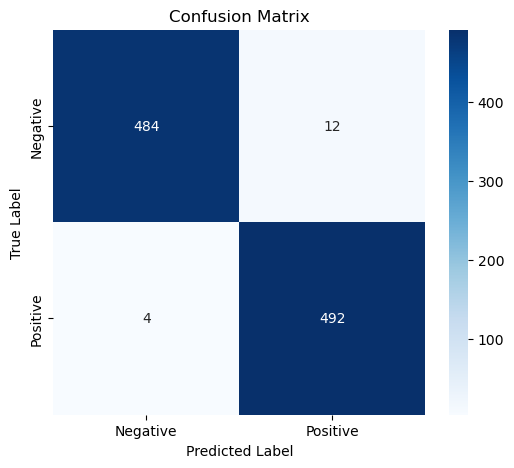

In [17]:
# Cell 7
# Evaluate the model on the test set

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

# Predict test set
y_pred = net.predict(X_test_tensor)

# Accuracy
test_accuracy = accuracy_score(y_test_tensor, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test_tensor, y_pred, target_names=["Negative", "Positive"]))

# Confusion Matrix
cm = confusion_matrix(y_test_tensor, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Cell 8
# Save the trained model and vocabulary for future use

import pickle
import torch

# Save the model to a .pt file
model_filename = "sentiment_model.pt"
torch.save(net.module_.state_dict(), model_filename)

# Save the vocabulary to a .pkl file
vocab_filename = "vocab.pkl"
with open(vocab_filename, "wb") as f:
    pickle.dump(vocab, f)

print(f"Model saved to {model_filename}")
print(f"Vocabulary saved to {vocab_filename}")

Model saved to sentiment_model.pt
Vocabulary saved to vocab.pkl


In [19]:
# Cell 9 (Fixed)
# Load the model and vocab, and define a function to classify new reviews

# Load vocab
with open("vocab.pkl", "rb") as f:
    vocab = pickle.load(f)

# Rebuild the CNN model architecture
model = CNNTextClassifier(
    vocab_size=len(vocab),
    embed_dim=100,
    output_dim=2
)
model.load_state_dict(torch.load("sentiment_model.pt", map_location=device))
model.to(device)
model.eval()

# Prediction helper
def demo_predict(review_text):
    # Clean and tokenize
    tokens = tokenize(review_text)
    sequence = [vocab.get(token, vocab["<UNK>"]) for token in tokens]
    sequence = pad_sequence_to_length(torch.tensor(sequence), max_seq_length)
    sequence = sequence.unsqueeze(0).to(device)  # add batch dimension

    with torch.no_grad():
        output = model(sequence)
        prediction = torch.argmax(output, dim=1).item()

    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Review: \"{review_text}\"\n→ Predicted Sentiment: {sentiment}")

/var/folders/xn/w6z3j4vd127b0bl1rtcq42vr0000gn/T/ipykernel_40762/3238424970.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sentiment_

In [20]:
# Cell 10
# Classify 10 sample reviews (SCOPE-style)

scope_reviews = [
    "This class was a total mess — lectures never made any sense.",
    "Great class! I learned a lot and the professor was very helpful.",
    "I felt like I was teaching myself most of the time.",
    "The group projects were painful but I did enjoy the content.",
    "Clear grading, fair assignments, and useful material. Would recommend.",
    "SCOPE is life-changing... in the worst possible way.",
    "Labs were fun but lectures were a bit slow.",
    "Excellent pacing, feedback was always prompt.",
    "Hard to follow, exams didn't reflect what we learned.",
    "Everything was organized and the TA support was awesome."
]

print("🔎 SCOPE Review Predictions:\n")
for review in scope_reviews:
    demo_predict(review)
    print("-" * 80)

🔎 SCOPE Review Predictions:

Review: "This class was a total mess — lectures never made any sense."
→ Predicted Sentiment: Negative
--------------------------------------------------------------------------------
Review: "Great class! I learned a lot and the professor was very helpful."
→ Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Review: "I felt like I was teaching myself most of the time."
→ Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Review: "The group projects were painful but I did enjoy the content."
→ Predicted Sentiment: Positive
--------------------------------------------------------------------------------
Review: "Clear grading, fair assignments, and useful material. Would recommend."
→ Predicted Sentiment: Negative
--------------------------------------------------------------------------------
Review: "SCOPE is life-changing... in the wors